# FIT5202 Assignment 2A : Building Models for Realtime Food Delivery Prediction

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Hyperparameter Tuning and Model Optimisation](#part-3)  
Please add code/markdown cells as needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Spark SQL usage is discouraged, and you can only use pandas to format results. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. Please use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 16MB, and to run locally with 4 CPU cores on your machine . 

In [328]:
from pyspark import SparkConf  # Import SparkConf to configure Spark application
from pyspark.sql import SparkSession  # Import SparkSession to manage the Spark application

# Define Spark master URL and application name
master = "local[4]"  # only using 4 CPU cores
app_name = "FIT5202Ass2A"  # Name of the Spark application

# Configure SparkConf object with master URL and application name
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Create a SparkSession with additional configuration, such as max partition size
spark = SparkSession.builder \
    .config(conf=spark_conf) \
    .config("spark.files.maxPartitionBytes", "16777216") \
    .getOrCreate() ## Set max partition size to 16MB，16MB = 16777216 Bytes

# Get SparkContext and set log level to ERROR
sc = spark.sparkContext
sc.setLogLevel("ERROR")  # Only log error messages to reduce log output

1.1.2 Write code to define the schemas for the datasets, following the data types suggested in the metadata. Then, using predefined schemas, write code to load the CSV files into separate data frames. Print the schemas of all data frames. 

In [329]:
# Import required modules from PySpark
from pyspark.sql.types import *  # For defining schema and data types
import pyspark.sql.functions as F  # For performing operations on DataFrames

In [330]:
# Define the schema for delivery_address.csv
address_schema = StructType([
    StructField("gid", StringType(), True),  # ID of delivery address geolocation
    StructField("street_name", StringType(), True),
    StructField("street_type", StringType(), True),
    StructField("suburb", StringType(), True),
    StructField("postcode", IntegerType(), True),
    StructField("state", StringType(), True),
    StructField("latitude", DoubleType(), True),  # Latitude with 6 decimal precision
    StructField("longitude", DoubleType(), True),  # Geometry point on maps
    StructField("geom", StringType(), True), 
    StructField("delivery_id", StringType(), True)  # ID of a delivery address
])

In [331]:
# Read the delivery_address.csv file into a DataFrame using the defined schema
df_address = spark.read.csv("./delivery_address.csv", header=True, schema=address_schema)

In [332]:
# Define the schema for driver.csv
driver_schema = StructType([
    StructField("driver_id", StringType(), True),  # Unique identifier of delivery person/driver
    StructField("age", IntegerType(), True),  # Driver's age, range 18-60
    StructField("rating", DoubleType(), True),  # Overall rating of the driver (float, 0-5 scale)
    StructField("year_experience", IntegerType(), True),  # Years of delivery experience
    StructField("vehicle_condition", StringType(), True),  # Vehicle condition: 0 (Good), 1 (Fair), 2 (Poor)
    StructField("type_of_vehicle", StringType(), True)  # Type of vehicle (Motorcycle, Scooter, etc.)
])

In [333]:
# Read the driver.csv file into a DataFrame using the defined schema
df_driver = spark.read.csv("./driver.csv", header=True, schema=driver_schema)

In [334]:
# Define the schema for order.csv
order_schema = StructType([
    StructField("order_id", StringType(), True),  # Unique identifier of an order
    StructField("delivery_person_id", IntegerType(), True),  # ID of the driver delivering the order
    StructField("order_ts", IntegerType(), True),  # Timestamp when an order is placed
    StructField("ready_ts", IntegerType(), True),  # Timestamp when the order is ready
    StructField("weather_condition", StringType(), True),  # Weather condition during the order
    StructField("road_condition", StringType(), True),  # Road condition during the order
    StructField("type_of_order", StringType(), True),  # Type of order (Snacks, Meals, Drinks, etc.)
    StructField("order_total", IntegerType(), True),  # Total value of the order
    StructField("delivery_time", IntegerType(), True),  # Delivery time excluding preparation time
    StructField("travel_distance", FloatType(), True),  # Total travel distance for the delivery
    StructField("restaurant_id", StringType(), True),
    StructField("delivery_id", StringType(), True)
])

In [335]:
# Read the order.csv file into a DataFrame using the defined schema
df_order = spark.read.csv("./order.csv", header=True, schema=order_schema)

In [336]:
# Define the schema for restaurants.csv
restaurant_schema = StructType([
    StructField("row_id", IntegerType(), True),  # Row ID of the restaurant
    StructField("restaurant_code", StringType(), True),  # Internal code of a restaurant
    StructField("chain_id", StringType(), True),  # Chain ID (empty if not part of a chain)
    StructField("primary_cuisine", StringType(), True),  # Primary cuisine of the restaurant
    StructField("latitude", DoubleType(), True),  # Latitude with 6 decimal precision
    StructField("longitude", DoubleType(), True),  # Geometry point on maps
    StructField("geom", StringType(), True),  # Geometry point of the restaurant
    StructField("restaurant_id", StringType(), True),  # ID of a restaurant (primary key for join)
    StructField("suburb", StringType(), True),
    StructField("postcode", IntegerType(), True)
])

In [337]:
# Read the restaurants.csv file into a DataFrame using the defined schema
df_restaurant = spark.read.csv("./restaurants.csv", header=True, schema=restaurant_schema)

In [338]:
# Print the schema of the delivery_address.csv DataFrame
df_address.printSchema()

root
 |-- gid: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- street_type: string (nullable = true)
 |-- suburb: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- geom: string (nullable = true)
 |-- delivery_id: string (nullable = true)



In [339]:
# Print the schema of the driver.csv DataFrame
df_driver.printSchema()

root
 |-- driver_id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- year_experience: integer (nullable = true)
 |-- vehicle_condition: string (nullable = true)
 |-- type_of_vehicle: string (nullable = true)



In [340]:
# Print the schema of the order.csv DataFrame
df_order.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- delivery_person_id: integer (nullable = true)
 |-- order_ts: integer (nullable = true)
 |-- ready_ts: integer (nullable = true)
 |-- weather_condition: string (nullable = true)
 |-- road_condition: string (nullable = true)
 |-- type_of_order: string (nullable = true)
 |-- order_total: integer (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- travel_distance: float (nullable = true)
 |-- restaurant_id: string (nullable = true)
 |-- delivery_id: string (nullable = true)



In [341]:
# Print the schema of the restaurants.csv DataFrame
df_restaurant.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- restaurant_code: string (nullable = true)
 |-- chain_id: string (nullable = true)
 |-- primary_cuisine: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- geom: string (nullable = true)
 |-- restaurant_id: string (nullable = true)
 |-- suburb: string (nullable = true)
 |-- postcode: integer (nullable = true)



### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
Feature engineering involves transforming, combining or extracting information from the raw data to create more informative and relevant features that improve the performance of your ML models.  
In our food delivery use case, the order_ts is not very useful when it is treated as a timestamp.  
However, it provides more information if you perform transformation and extract valuable information from it, for example, extracting the day of the week (it may tell you how busy a restaurant is) or hours (peak hours may have bad traffic conditions).   
(Note: Some tasks may overlap with A1, feel free to use/reuse your own code/UDF from A1.)  
  
Perform the following tasks based on the loaded data frames and create a new one. We will refer to this as feature_df, but feel free to use your own naming. (2% each) 
Please print 5 rows from the feature_df after each step.


1.2.1 Extract the day of the week (Monday-Sunday) and hour of the day (0-23) from order_ts, and store the extract information in 2 columns.

In [342]:
# Import necessary modules
from pyspark.sql import SparkSession  # For creating a Spark session
from pyspark.sql.functions import col, udf  # For column operations and defining UDFs
from pyspark.sql.types import StringType, IntegerType  # For defining UDF return types

# Step 1: Initialize Spark session
# Create a Spark session for processing the dataset
spark = SparkSession.builder.appName("A2_Task").getOrCreate()

# Step 2: Define UDFs for day of the week and hour of the day
# UDF to extract the day of the week (e.g., Monday, Tuesday) from a UNIX timestamp
def get_day_of_week(unix_time):
    from datetime import datetime
    return datetime.utcfromtimestamp(unix_time).strftime('%A')  # Returns the day of the week

# UDF to extract the hour of the day (0-23) from a UNIX timestamp
def get_hour_of_day(unix_time):
    from datetime import datetime
    return datetime.utcfromtimestamp(unix_time).hour  # Returns the hour of the day

# Register UDFs for use with DataFrame columns
get_day_of_week_udf = udf(get_day_of_week, StringType())
get_hour_of_day_udf = udf(get_hour_of_day, IntegerType())

# Step 3: Load dataset
# Load the order.csv file into a DataFrame with headers and infer schema types
df_order = spark.read.csv("./order.csv", header=True, inferSchema=True)

# Step 4: Ensure order_ts is in the correct format
# Convert the order_ts column to long type to ensure it is a valid UNIX timestamp
df_order = df_order.withColumn("order_ts", col("order_ts").cast("long"))

# Step 5: Add day_of_week and hour_of_day columns
# Use UDFs to create two new columns: day_of_week and hour_of_day
# Select only the required columns: order_id, day_of_week, hour_of_day
feature_df = df_order \
    .withColumn("day_of_week", get_day_of_week_udf(col("order_ts"))) \
    .withColumn("hour_of_day", get_hour_of_day_udf(col("order_ts"))) \
    .select("order_id", "delivery_id", "day_of_week", "hour_of_day")  # Keep only the specified columns

# Step 6: Display the result
# Show the first 10 rows of the transformed DataFrame with all columns visible
feature_df.show(10, truncate=False)

+------------------------------------+-----------+-----------+-----------+
|order_id                            |delivery_id|day_of_week|hour_of_day|
+------------------------------------+-----------+-----------+-----------+
|02bccb12-7bb2-41c0-af35-3fe34f6e48f7|7530       |Monday     |20         |
|c805e0fd-2214-4dc6-b4bd-ef93bfc63d33|7355       |Wednesday  |21         |
|5aba5eac-ab01-4bfa-9805-2cf34a52109e|9140       |Tuesday    |5          |
|f258e133-bea0-46b3-80eb-13de47ff1325|23         |Wednesday  |10         |
|b8955ebc-2e67-4a9d-b49f-b56ba6cdcf7e|1765       |Wednesday  |11         |
|500cd68e-b7bb-4af4-8748-8140659183f5|8720       |Saturday   |21         |
|8b96a6c9-34d2-4fc2-9401-ab86a1b5a977|6536       |Sunday     |13         |
|3b52cfa9-8960-4406-93e0-a3489b7cc2ce|8818       |Saturday   |20         |
|8a3f6783-dfd7-4591-b7ec-764bee1ce97f|6074       |Friday     |21         |
|72c06040-5442-4dd7-ac2f-310c9a3462ca|4594       |Sunday     |5          |
+------------------------

1.2.2 Create a new boolean column (isPeak) to indicate peak/non-peak hours. (Peak hours are defined as 7-9 and 16-18 in 24-hour format.)

In [343]:
# Step 1: Define a UDF for detecting peak hours
# This UDF checks if the input hour (0-23) is within the peak hour range
# Peak hours are defined as [7, 8, 9, 16, 17, 18]
def is_peak_hour(hour):
    peak_hours = [7, 8, 9, 16, 17, 18]  # Define peak hours
    return hour in peak_hours  # Return True if the hour is a peak hour, False otherwise

# Register the UDF
is_peak_hour_udf = udf(is_peak_hour, StringType())  # UDF returns 'true' or 'false'

# Step 2: Add a new column to the DataFrame to identify peak hours
# Use the `withColumn` function and apply the UDF to the hour_of_day column
feature_df_with_peak = feature_df \
    .withColumn("is_peak", is_peak_hour_udf(col("hour_of_day"))) \
    .select("order_id", "delivery_id", "day_of_week", "hour_of_day", "is_peak")

# Step 3: Display the resulting DataFrame
# Show the first 10 rows of the transformed DataFrame
feature_df_with_peak.show(10, truncate=False)

+------------------------------------+-----------+-----------+-----------+-------+
|order_id                            |delivery_id|day_of_week|hour_of_day|is_peak|
+------------------------------------+-----------+-----------+-----------+-------+
|02bccb12-7bb2-41c0-af35-3fe34f6e48f7|7530       |Monday     |20         |false  |
|c805e0fd-2214-4dc6-b4bd-ef93bfc63d33|7355       |Wednesday  |21         |false  |
|5aba5eac-ab01-4bfa-9805-2cf34a52109e|9140       |Tuesday    |5          |false  |
|f258e133-bea0-46b3-80eb-13de47ff1325|23         |Wednesday  |10         |false  |
|b8955ebc-2e67-4a9d-b49f-b56ba6cdcf7e|1765       |Wednesday  |11         |false  |
|500cd68e-b7bb-4af4-8748-8140659183f5|8720       |Saturday   |21         |false  |
|8b96a6c9-34d2-4fc2-9401-ab86a1b5a977|6536       |Sunday     |13         |false  |
|3b52cfa9-8960-4406-93e0-a3489b7cc2ce|8818       |Saturday   |20         |false  |
|8a3f6783-dfd7-4591-b7ec-764bee1ce97f|6074       |Friday     |21         |false  |
|72c

1.2.3 Join the geolocation data frame of the restaurant and delivery location, get suburb information and add two columns.

In [364]:
# Rename delivery address and restaurant DataFrame columns to avoid conflicts during join
df_address_renamed = df_address \
    .withColumnRenamed("delivery_id", "address_delivery_id") \
    .withColumnRenamed("suburb", "address_suburb") \
    .withColumnRenamed("postcode", "address_postcode") \
    .withColumnRenamed("latitude", "address_latitude") \
    .withColumnRenamed("longitude", "address_longitude") \
    .withColumnRenamed("geom", "address_geom")

df_restaurant_renamed = df_restaurant \
    .withColumnRenamed("suburb", "restaurant_suburb") \
    .withColumnRenamed("postcode", "restaurant_postcode") \
    .withColumnRenamed("latitude", "restaurant_latitude") \
    .withColumnRenamed("longitude", "restaurant_longitude") \
    .withColumnRenamed("geom", "restaurant_geom")\
    .withColumnRenamed("restaurant_id", "restaurant_restaurant_id")

df_order_renamed = df_order \
    .withColumnRenamed("delivery_id", "order_delivery_id")\
    .withColumnRenamed("restaurant_id", "order_restaurant_id")

In [365]:
from pyspark.sql.functions import col

# Join delivery address data with orders using order_delivery_id
df_with_delivery_suburb = df_order_renamed.join(
    df_address_renamed,
    col("order_delivery_id") == col("address_delivery_id"),
    how="left"
).drop("address_delivery_id")  # Remove duplicate column

# Join restaurant data with orders using order_restaurant_id
df_with_geolocation = df_with_delivery_suburb.join(
    df_restaurant_renamed,
    col("order_restaurant_id") == col("restaurant_restaurant_id"),
    how="left"
).drop("restaurant_restaurant_id")  # Remove duplicate column

# Select required columns and show the result
df_with_geolocation.select("order_id", "address_suburb", "restaurant_suburb").show(10, truncate=False)

+------------------------------------+---------------+-----------------+
|order_id                            |address_suburb |restaurant_suburb|
+------------------------------------+---------------+-----------------+
|02bccb12-7bb2-41c0-af35-3fe34f6e48f7|SOUTH YARRA    |EAST MELBOURNE   |
|c805e0fd-2214-4dc6-b4bd-ef93bfc63d33|PRAHRAN        |KENSINGTON       |
|5aba5eac-ab01-4bfa-9805-2cf34a52109e|PORT MELBOURNE |PORT MELBOURNE   |
|f258e133-bea0-46b3-80eb-13de47ff1325|MELBOURNE      |PARKVILLE        |
|b8955ebc-2e67-4a9d-b49f-b56ba6cdcf7e|MELBOURNE      |CARLTON          |
|500cd68e-b7bb-4af4-8748-8140659183f5|NORTH MELBOURNE|PORT MELBOURNE   |
|8b96a6c9-34d2-4fc2-9401-ab86a1b5a977|WEST MELBOURNE |SOUTH MELBOURNE  |
|3b52cfa9-8960-4406-93e0-a3489b7cc2ce|SOUTH YARRA    |EAST MELBOURNE   |
|8a3f6783-dfd7-4591-b7ec-764bee1ce97f|SOUTH YARRA    |SOUTH YARRA      |
|72c06040-5442-4dd7-ac2f-310c9a3462ca|DOCKLANDS      |NORTH MELBOURNE  |
+------------------------------------+-------------

1.2.4 Join data frames to add restaurant information to the feature_df: primary_cuisine, latitude, longitude, suburb and postcode.

In [367]:
from pyspark.sql.functions import col

# Join restaurant DataFrame with feature_df using restaurant_id
df_with_restaurant_info = feature_df.join(
    df_restaurant_renamed,
    col("order_restaurant_id") == col("restaurant_restaurant_id"),
    how="left"  # Ensure "how" is passed as a string
).drop("restaurant_restaurant_id")  # Remove duplicate column after join

# Select required columns and add restaurant information
df_with_restaurant_info_selected = df_with_restaurant_info.select(
    "primary_cuisine",
    "restaurant_latitude",
    "restaurant_longitude",
    "restaurant_suburb",
    "restaurant_postcode"
)

# Display the final DataFrame
df_with_restaurant_info_selected.show(10, truncate=False)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `order_restaurant_id` cannot be resolved. Did you mean one of the following? [`restaurant_code`, `restaurant_restaurant_id`, `restaurant_geom`, `delivery_id`, `order_id`].;
'Join LeftOuter, ('order_restaurant_id = restaurant_restaurant_id#16887)
:- Project [order_id#14686, delivery_id#14697, day_of_week#14725, hour_of_day#14740]
:  +- Project [order_id#14686, delivery_person_id#14687, order_ts#14710L, ready_ts#14689, weather_condition#14690, road_condition#14691, type_of_order#14692, order_total#14693, delivery_time#14694, travel_distance#14695, restaurant_id#14696, delivery_id#14697, day_of_week#14725, get_hour_of_day(order_ts#14710L)#14739 AS hour_of_day#14740]
:     +- Project [order_id#14686, delivery_person_id#14687, order_ts#14710L, ready_ts#14689, weather_condition#14690, road_condition#14691, type_of_order#14692, order_total#14693, delivery_time#14694, travel_distance#14695, restaurant_id#14696, delivery_id#14697, get_day_of_week(order_ts#14710L)#14724 AS day_of_week#14725]
:        +- Project [order_id#14686, delivery_person_id#14687, cast(order_ts#14688 as bigint) AS order_ts#14710L, ready_ts#14689, weather_condition#14690, road_condition#14691, type_of_order#14692, order_total#14693, delivery_time#14694, travel_distance#14695, restaurant_id#14696, delivery_id#14697]
:           +- Relation [order_id#14686,delivery_person_id#14687,order_ts#14688,ready_ts#14689,weather_condition#14690,road_condition#14691,type_of_order#14692,order_total#14693,delivery_time#14694,travel_distance#14695,restaurant_id#14696,delivery_id#14697] csv
+- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, restaurant_latitude#16854, restaurant_longitude#16865, restaurant_geom#16876, restaurant_id#14656 AS restaurant_restaurant_id#16887, restaurant_suburb#16832, restaurant_postcode#16843]
   +- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, restaurant_latitude#16854, restaurant_longitude#16865, geom#14655 AS restaurant_geom#16876, restaurant_id#14656, restaurant_suburb#16832, restaurant_postcode#16843]
      +- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, restaurant_latitude#16854, longitude#14654 AS restaurant_longitude#16865, geom#14655, restaurant_id#14656, restaurant_suburb#16832, restaurant_postcode#16843]
         +- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, latitude#14653 AS restaurant_latitude#16854, longitude#14654, geom#14655, restaurant_id#14656, restaurant_suburb#16832, restaurant_postcode#16843]
            +- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, latitude#14653, longitude#14654, geom#14655, restaurant_id#14656, restaurant_suburb#16832, postcode#14658 AS restaurant_postcode#16843]
               +- Project [row_id#14649, restaurant_code#14650, chain_id#14651, primary_cuisine#14652, latitude#14653, longitude#14654, geom#14655, restaurant_id#14656, suburb#14657 AS restaurant_suburb#16832, postcode#14658]
                  +- Relation [row_id#14649,restaurant_code#14650,chain_id#14651,primary_cuisine#14652,latitude#14653,longitude#14654,geom#14655,restaurant_id#14656,suburb#14657,postcode#14658] csv


1.2.5 Add columns you deem necessary from the dataset (at least one column is required). (hint: delivery driver’s vehicle type may affect the delivery time.)

In [368]:
# Step 1: Rename columns in driver.csv to avoid conflicts
df_driver_renamed = df_driver \
    .withColumnRenamed("driver_id", "driver_driver_id")

# Step 2: Ensure data types match between join columns
df_order_renamed = df_order \
    .withColumnRenamed("delivery_person_id", "order_delivery_person_id") \
    .withColumn("order_delivery_person_id", col("order_delivery_person_id").cast("string"))

df_driver_renamed = df_driver_renamed \
    .withColumn("driver_driver_id", col("driver_driver_id").cast("string"))

# Step 3: Perform the join to add type_of_vehicle to order DataFrame
df_order_with_vehicle = df_order_renamed.join(
    df_driver_renamed.select("driver_driver_id", "type_of_vehicle"),
    df_order_renamed["order_delivery_person_id"] == df_driver_renamed["driver_driver_id"],
    how="left"  # Use left join to retain all orders even if no matching driver is found
)

# Step 4: Select relevant columns, including the new type_of_vehicle column
result_df = df_order_with_vehicle.select(
    "order_id",  # Keep all columns from the original order DataFrame
    "order_delivery_person_id",
    "type_of_vehicle",
    "order_ts",
    "delivery_time",
    "order_total"
)

# Step 5: Display the schema and data
result_df.show(10, truncate=False)

+------------------------------------+------------------------+---------------+----------+-------------+-----------+
|order_id                            |order_delivery_person_id|type_of_vehicle|order_ts  |delivery_time|order_total|
+------------------------------------+------------------------+---------------+----------+-------------+-----------+
|02bccb12-7bb2-41c0-af35-3fe34f6e48f7|1313                    |Car            |1733172480|3            |13         |
|c805e0fd-2214-4dc6-b4bd-ef93bfc63d33|1589                    |Scooter        |1712178816|7            |80         |
|5aba5eac-ab01-4bfa-9805-2cf34a52109e|1554                    |Motorcycle     |1721109376|30           |20         |
|f258e133-bea0-46b3-80eb-13de47ff1325|1520                    |eBike          |1713955200|29           |5          |
|b8955ebc-2e67-4a9d-b49f-b56ba6cdcf7e|1763                    |Bike           |1710328448|4            |202        |
|500cd68e-b7bb-4af4-8748-8140659183f5|1625                    |B

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
1.3.1	With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b) For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count. 

In [361]:
from IPython.display import display

# Numeric summary
print("Numeric column statistics:")
display(numeric_summary.style.set_table_attributes("style='display:inline'").set_caption("Numeric Summary"))

# Categorical columns
print("\nTop 5 values for categorical columns:")
for col in categorical_cols:
    top_5 = (
        feature_df.groupBy(col)
        .count()
        .orderBy(F.col("count").desc())
        .limit(5)
        .toPandas()
    )
    print(f"\nColumn: {col}")
    display(top_5.style.set_table_attributes("style='display:inline'").set_caption(f"Top 5 Values for {col}"))

# Boolean columns
print("\nValue counts for boolean columns:")
if boolean_cols:
    for col in boolean_cols:
        value_counts = (
            feature_df.groupBy(col).count().orderBy(F.col(col)).toPandas()
        )
        print(f"\nColumn: {col}")
        display(value_counts.style.set_table_attributes("style='display:inline'").set_caption(f"Value Counts for {col}"))
else:
    print("No boolean columns found.")

Numeric column statistics:


,delivery_id,hour_of_day
summary,,
count,949338,949338
mean,5001.854741935959,11.495019687403222
stddev,2887.1116688540965,6.921775702510894
min,1,0
25%,2501,6
50%,5003,11
75%,7506,17
max,10000,23



Top 5 values for categorical columns:

Column: order_id


,order_id,count
0,d940da30-7ee2-4c3a-83a1-74840774332b,1
1,ec82849d-3460-42f8-a183-f57a7c2197c2,1
2,4f441bba-805b-4d06-8c4b-8da5671f0ffc,1
3,837234ba-ddd1-4557-acbe-f09819b2fca3,1
4,96bc9579-f6df-4146-814e-503980acbad6,1



Column: day_of_week


,day_of_week,count
0,Sunday,137504
1,Monday,137276
2,Tuesday,136344
3,Saturday,135734
4,Thursday,134271



Value counts for boolean columns:
No boolean columns found.


1.3.2 2.	Explore the dataframe and write code to present two plots, describe your plots and discuss the findings from the plots. (20%) .  
○	One of the plots must be related to our use case (predicting delivery time).   
○	Hint 1: You can use basic plots (e.g., histograms, line charts, scatter plots) to show the relationship between a column and the label or use more advanced plots like correlation plots.  
○	Hint 2: If your data is too large for plotting, consider using sampling before plotting.  
○	150 words max for each plot’s description and discussion  
○	Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  

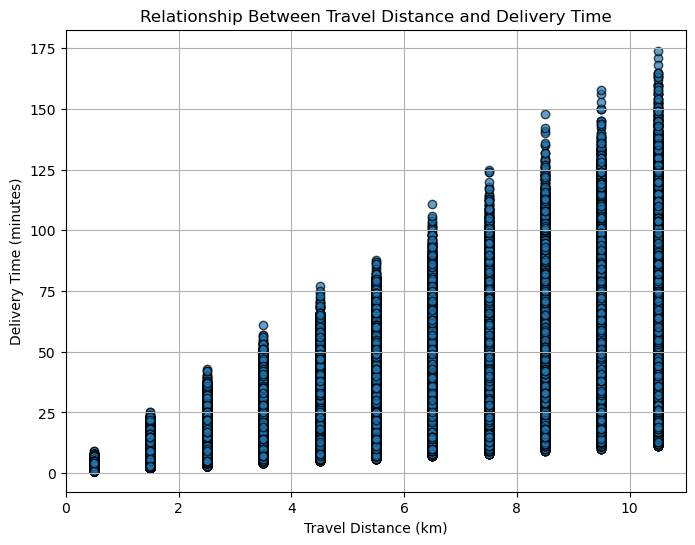


Analysis of Scatter Plot:
The scatter plot shows a positive correlation between travel distance and delivery time.
As the travel distance increases, the delivery time also tends to increase, which aligns with expectations.
However, further analysis is required to account for other factors such as traffic and weather conditions that may also influence delivery time.



In [350]:
import pandas as pd
import matplotlib.pyplot as plt

# read the order.csv
file_path = './order.csv'
df = pd.read_csv(file_path)

# Select the desired column and remove the missing values
df = df[['travel_distance', 'delivery_time']].dropna()

# Draw the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['travel_distance'], df['delivery_time'], alpha=0.7, edgecolor='k')
plt.title('Relationship Between Travel Distance and Delivery Time')
plt.xlabel('Travel Distance (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()

# 150 words analysis
print("""
Analysis of Scatter Plot:
The scatter plot shows a positive correlation between travel distance and delivery time.
As the travel distance increases, the delivery time also tends to increase, which aligns with expectations.
However, further analysis is required to account for other factors such as traffic and weather conditions that may also influence delivery time.
""")

<Figure size 1000x600 with 0 Axes>

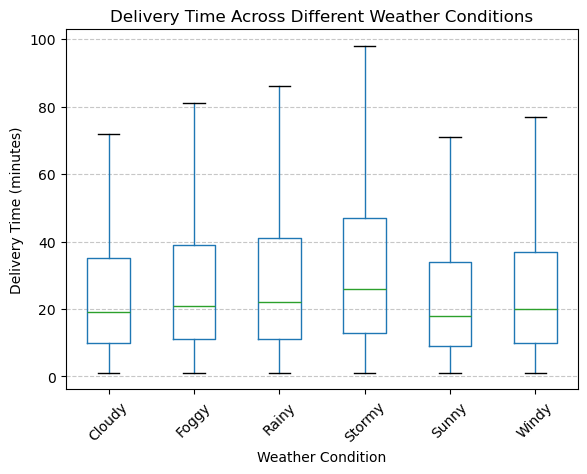


Analysis of Box Plot:
The box plot shows the distribution of delivery times under different weather conditions.
From the plot, we can observe how extreme weather (e.g., Rainy or Stormy) might increase
the delivery time due to safety precautions and slower travel speeds.
Sunny and Windy conditions generally exhibit shorter delivery times. The findings emphasize
that weather conditions significantly influence delivery efficiency.



In [352]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the order.csv
file_path = './order.csv'
df = pd.read_csv(file_path)

# Select the desired column and remove the missing values
df = df[['weather_condition', 'delivery_time']].dropna()

# Draw the box plot
plt.figure(figsize=(10, 6))
df.boxplot(column='delivery_time', by='weather_condition', grid=False, showfliers=False)
plt.title('Delivery Time Across Different Weather Conditions')
plt.suptitle('')
plt.xlabel('Weather Condition')
plt.ylabel('Delivery Time (minutes)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 150 words analysis
print("""
Analysis of Box Plot:
The box plot shows the distribution of delivery times under different weather conditions.
From the plot, we can observe how extreme weather (e.g., Rainy or Stormy) might increase
the delivery time due to safety precautions and slower travel speeds.
Sunny and Windy conditions generally exhibit shorter delivery times. The findings emphasize
that weather conditions significantly influence delivery efficiency.
""")


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, should not be used to process the data; however, it’s fine to use them to display the result or evaluate your model.  
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you plan to create/transform them.  
○	300 words max for the discussion  
○	Please only use the provided data for model building  
○	You can create/add additional features based on the dataset  
○	Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns  

Predicting delivery time effectively requires selecting features that have a direct impact on the outcome and removing those that do not contribute to the prediction. Columns like order_id, delivery_id, and delivery_person_id are random identifiers that are unique to each record and do not influence the delivery time prediction. These columns can be safely removed as they introduce unnecessary noise without adding any predictive value.
Among the most important features to retain and enhance is the delivery_geodistance. This column, calculated using the Euclidean distance between the latitude and longitude of the restaurant and the delivery address, directly reflects the spatial distance involved in the delivery. This feature provides a crucial measure that impacts delivery times, capturing the physical distance as an essential predictor.
No additional features like preparation time or time-of-day categorization will be added, as the focus remains solely on incorporating delivery_geodistance while simplifying the feature set. By minimizing the complexity of the dataset and focusing on core predictors, we aim to build a robust and interpretable model. With this approach, we ensure that the data preparation process prioritizes clarity and relevance, enabling the model to deliver accurate predictions efficiently.

2.1.2 Write code to create/transform the columns based on your discussion above.

In [356]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, pow

# Initialize Spark session
spark = SparkSession.builder.appName("Feature Engineering").getOrCreate()

# Load datasets
order_df = spark.read.csv("order.csv", header=True, inferSchema=True)
restaurant_df = spark.read.csv("restaurants.csv", header=True, inferSchema=True)
delivery_address_df = spark.read.csv("delivery_address.csv", header=True, inferSchema=True)

# Rename columns to avoid naming conflicts during joins
restaurant_df = restaurant_df \
    .withColumnRenamed("restaurant_id", "restaurant_restaurant_id") \
    .withColumnRenamed("latitude", "restaurant_latitude") \
    .withColumnRenamed("longitude", "restaurant_longitude")

delivery_address_df = delivery_address_df \
    .withColumnRenamed("delivery_id", "address_delivery_id") \
    .withColumnRenamed("latitude", "address_latitude") \
    .withColumnRenamed("longitude", "address_longitude")

order_df = order_df \
    .withColumnRenamed("restaurant_id", "order_restaurant_id") \
    .withColumnRenamed("delivery_id", "order_delivery_id")

# Join restaurant data with order DataFrame
order_df = order_df.join(
    restaurant_df.select("restaurant_restaurant_id", "restaurant_latitude", "restaurant_longitude"),
    order_df["order_restaurant_id"] == restaurant_df["restaurant_restaurant_id"],
    "left"
)

# Join delivery address data with order DataFrame
order_df = order_df.join(
    delivery_address_df.select("address_delivery_id", "address_latitude", "address_longitude"),
    order_df["order_delivery_id"] == delivery_address_df["address_delivery_id"],
    "left"
)

# Calculate delivery_geodistance using Euclidean approximation
order_df = order_df.withColumn(
    "delivery_geodistance",
    sqrt(pow(col("restaurant_latitude") - col("address_latitude"), 2) + pow(col("restaurant_longitude") - col("address_longitude"), 2))
)

# Drop irrelevant columns
columns_to_drop = ["order_id", "order_delivery_id", "delivery_person_id"]
order_df = order_df.drop(*columns_to_drop)

# Show the final transformed DataFrame
order_df.show()

+----------+----------+-----------------+--------------+-------------+-----------+-------------+---------------+-------------------+------------------------+-------------------+--------------------+-------------------+----------------+-----------------+--------------------+
|  order_ts|  ready_ts|weather_condition|road_condition|type_of_order|order_total|delivery_time|travel_distance|order_restaurant_id|restaurant_restaurant_id|restaurant_latitude|restaurant_longitude|address_delivery_id|address_latitude|address_longitude|delivery_geodistance|
+----------+----------+-----------------+--------------+-------------+-----------+-------------+---------------+-------------------+------------------------+-------------------+--------------------+-------------------+----------------+-----------------+--------------------+
|1733172480|1733172608|            Rainy|           Low|       Drinks|         13|            3|            1.5|                909|                     909|       -37.8173623

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing, using 2025 as the random seed. You can decide the train/test split ratio based on the resources available on your laptop.  
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset). 

### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

2.4.2 For both models (RF and GBT): with the test data, decide on which metrics to use for model evaluation and discuss which one is the better model (no word limit; please keep it concise). You may also use a plot for visualisation (not mandatory).

2.4.3 3.	Save the better model (you’ll need it for A2B).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

### Part 3. Hyperparameter Tuning and Model Optimisation <a class="anchor" name="part-3"></a>  
Apply the techniques you have learnt from the labs, for example, CrossValidator, TrainValidationSplit, ParamGridBuilder, etc., to perform further hyperparameter tuning and model optimisation.  
The assessment is based on the quality of your work/process, not the quality of your model. Please include your thoughts/ideas/discussions.

## References:
Please add your references below: